# Introduction to the BAREFOOT Framework
## A Bayesian Optimization Framework for Optimization of Multi-Fidelity Models

### 1) A brief introduction to the Reification/Fusion approach used in BAREFOOT

The reification/fusion approach is an approach for fusing models of varying fidelities \[1\]. In this context, model fidelity is defined as the accuracy of a model with respect to a Ground Truth. This Ground Truth can be either a highly accurate (typically FEM based) computational model, or experimental data.

For the purposes of this demonstration of the reification, fusion approach, we will use a simple ground truth model, namely a sine function (in this case we won't consider noise, but the approach works just as well with noisy data),

$$ f_{truth}(x) = sin(x)$$

and two reduced order models which are obtained from the Taylor expansion of the sine function,

$$ f_1(x) = (x-0.1) - \frac{(x-0.1)^3}{3!} + \frac{(x-0.1)^5}{5!}$$

$$ f_2(x) = (x+0.3) - \frac{(x+0.1)^3}{3!} + \frac{(x-0.1)^5}{5!}$$

Before we start we need to make some imports for necessary modules for the entire demonstration

In [ ]:
# First: Some necessary imports
import numpy as np
import matplotlib.pyplot as plt
from pickle import dump, load
from gpModel import gp_model
from reificationFusion import model_reification
from pyDOE import lhs
from copy import deepcopy
from mechModels import isostrain_IS, isostress_IS, isowork_IS, TC_GP, RVE_GP
from util import cartesian
from acquisitionFunc import expected_improvement

The implmenentation of the of the models that we will use is straightforward.

In [ ]:
def truth_model(x):
    return np.sin(x)

def model1(x):
    return (x-0.1) - ((x-0.1)**3)/6 + ((x-0.1)**5)/120

def model2(x):
    return (x+0.3) - ((x+0.1)**3)/6 + ((x-0.1)**5)/120

Now let us define a set of input points to use to show how the models look.

In [ ]:
x_plot = np.linspace(-3,3,100)

Then we can query the values from each of the models.

In [ ]:
y_tm = truth_model(x_plot)
y_m1 = model1(x_plot)
y_m2 = model2(x_plot)

And plot the results.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
ax.plot(x_plot, y_tm, c='#aa0000', linestyle='--', label="Ground Truth Model")
ax.plot(x_plot, y_m1, c='#00aa00', label='Reduced Order Model 1')
ax.plot(x_plot, y_m2, c='#0000aa', label='Reduced Order Model 2')
ax.legend()

As can be observed, the two reduced order models are both relatively good predictors of the ground truth, however neither really matches the ground truth model perfectly. Using this information we can now proceed with the Reification/Fusion approach.

The Reification/Fusion approach consists of three steps: 

a) Adding Model Discrepancy 

b) Reification of the models and 

c) Model Fusion.


Model fusion is easiest when the correlation between the models is known, however, in most cases this correlation is not known. As a result, the reification approach approximates the correlation between the models so that the models can be fused easily.

##### a) Adding Model Discrepancy
The model discrepancy is defined as the opposite of model fidelity. In other words, model discrepancy is the difference between the model and the ground truth. And this is exactly how we calculate it. As seen in the figure below. if we have some points evaluated from the ground truth, and the reduced order model. By fitting a Gaussian Process (GP) model to the reduced order model data we have a surrogate that has a mean prediction and a variance. The figure shows the shaded area as the standard deviation. To obtain the discrepancy for the model, we evaluate the difference between the GP surrogate model and the ground truth data *at all points where the ground truth is evaluated*. 

Using these differences, we construct another GP surrogate model to predict the difference over the entire design space. Then we define the total standard deviation ($\sigma_{T}$) as the sum of the discrepancy and the standard deviation of the GP surrogate model for the reduced order model. 

$$\sigma_{T} = \sigma_{GP} + \sigma_{d} $$

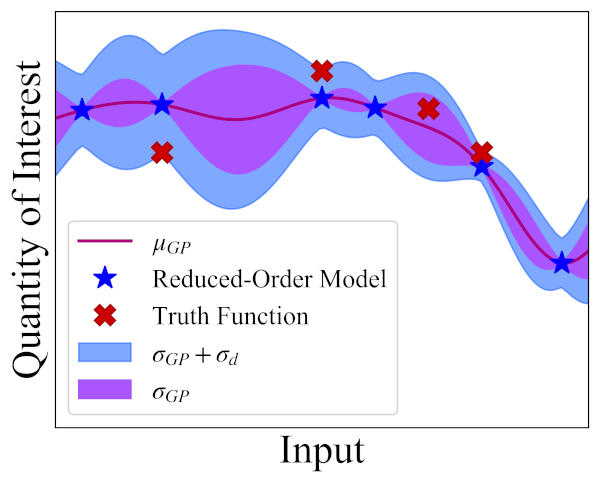
    
In the subsequent analysis, the error for each of the models ($\delta$) is defined as a normal distribution with zero mean and variance of $\sigma_T^2$ or $\delta\sim\mathcal{N}(0,\sigma_{T}^2)$.
    
So how does this apply to the example models above?

Let's assume that we have 10 evaluations of each model, and for simplicity, these evaluations are all at the same points:

In [ ]:
x_test = np.linspace(-3,3,num=10)

Now, we evaluate these points from each of the models and let's plot them on the previous plots to visualize how the data is dispersed in the region.

In [ ]:
y_tm_eval = truth_model(x_test)
y_m1_eval = model1(x_test)
y_m2_eval = model2(x_test)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
ax.plot(x_plot, y_tm, c='#aa0000', linestyle='--', label="Ground Truth Model")
ax.scatter(x_test, y_tm_eval, c='#aa0000', marker='D')
ax.plot(x_plot, y_m1, c='#00aa00', label='Reduced Order Model 1')
ax.scatter(x_test, y_m1_eval, c='#00aa00', marker='D')
ax.plot(x_plot, y_m2, c='#0000aa', label='Reduced Order Model 2')
ax.scatter(x_test, y_m2_eval, c='#0000aa', marker='D')
ax.legend()

Now let us plot the discrepancy between the two models and the ground truth values. We'll use this information to create the discrepancy models. We take the absolute value of the discrepancy since the we need the standard deviation to be positive.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
ax.plot(x_test, np.abs(y_tm_eval-y_m1_eval), c='#00aa00', label='ROM 1 Discrepancy')
ax.plot(x_test, np.abs(y_tm_eval-y_m2_eval), c='#0000aa', label='ROM 2 Discrepancy')
ax.legend()

From this we can see the Model 1 is more accurate than Model 2 over most of the domain, however, above around $x=2$ Model 2 is more accurate. And so the next step is to fit both the evaluated points and the discrepancy with Gaussian Process models so that we can obtain the mean and total variance estimates over the design space.

To do this, we will use the gp_model function that acts as a wrapper for the george.py module. This wrapper allows us to specify a GP model by providing the input and output values along with a characteristic length scale, signal variance ($\sigma_f^2$), and noise variance ($\sigma_n^2$). These are highlighted as comments in the first gp_model call.

In [ ]:
gp_m1 = gp_model(x_test,    # Model input values to use as training data
                 y_m1_eval, # Model output values to use as training data
                 [0.8],     # Characteristic length scale, one value per dimension in the list
                 1,         # Signal variance 
                 0.05,      # Noise Variance
                 1,         # Number of dimensions, needs to be specified explicitly
                 "SE")      # Choice of covariance Function SE: Squared Exponential
gp_m2 = gp_model(x_test, y_m2_eval, [0.8], 1, 0.05, 1, "SE")

After building the GP models we will need to obtain their values over the entire sampling of the design space, which we specified as x_plot earlier.

In [ ]:
model1_mean, var1 = gp_m1.predict_var(x_plot)
model2_mean, var2 = gp_m2.predict_var(x_plot)

In addition to this, we need the GP values at the test points to calculate the model discrepancy.

In [ ]:
m1_m, m1_v = gp_m1.predict_var(x_test)
m2_m, m2_v = gp_m2.predict_var(x_test)

The discrepancies for each of the reduced order models are then calculated. Since this is effectively a standard deviation, we need to take the absolute value since the standard deviation must be a positive value.

In [ ]:
err1 = np.abs(y_tm_eval-m1_m)
err2 = np.abs(y_tm_eval-m2_m)

We can then use this information to construct the GP models for the discrepancy. For consistency with the manner in which this is coded in the BAREFOOT Framework we normalize the errors to be on the standard normal distribution. If possible, this is an ideal manner for constructing a GP model, since the outputs of the GP Model are by definition normally distributed, so having the training data following a normal distribution can result in a more stable and accurate GP Model.

In [ ]:
gp_err1 = gp_model(x_test, (err1-np.mean(err1))/np.std(err1), [0.8], 1, 0.05, 1, "SE")
gp_err2 = gp_model(x_test, (err2-np.mean(err2))/np.std(err2), [0.8], 1, 0.05, 1, "SE")

We can then use these Discrepancy GP Models to obtain the discrepancy over the entire domain at a much finer scale.

In [ ]:
mean_err1, var_err1 = gp_err1.predict_var(x_plot)
mean_err2, var_err2 = gp_err2.predict_var(x_plot)

But we do have to remember to convert the errors back from the normalized values.

In [ ]:
mean_err1 = mean_err1*np.std(err1)+np.mean(err1)
mean_err2 = mean_err2*np.std(err2)+np.mean(err2)

The total model error or variance can be calculated by adding the variance and the square of the mean predicted from the Discrepancy GP Models.

In [ ]:
model1_tot_err = (var1 + (mean_err1)**2)
model2_tot_err = (var2 + (mean_err2)**2)

Now we can plot the outputs showing the combined error and the mean prediction for each of the models.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax[0].fill_between(x_plot, model1_mean+2*np.sqrt(var1), model1_mean-2*np.sqrt(var1), alpha=0.75, fc="#00aa00", label="GP Error")
ax[0].fill_between(x_plot, model1_mean+2*(np.sqrt(var1)+mean_err1), model1_mean-2*(np.sqrt(var1)+mean_err1), alpha=0.5, fc="#00aa00", label="Total Error")
ax[0].plot(x_plot, model1_mean, c="#0000aa", linestyle="--", label="Model 1 Mean")
ax[0].plot(x_plot, y_tm, c="#000000", linestyle=":", label="Truth Model")
ax[0].set_title("Reduced Order Model 1")
ax[0].legend(loc="lower right")
ax[1].fill_between(x_plot, model2_mean+2*np.sqrt(var2), model2_mean-2*np.sqrt(var2), alpha=0.75, fc="#0000aa", label="GP Error")
ax[1].fill_between(x_plot, model2_mean+2*(np.sqrt(var2)+mean_err2), model2_mean-2*(np.sqrt(var2)+mean_err2), alpha=0.5, fc="#0000aa", label="Total Error")
ax[1].plot(x_plot, model2_mean, c="#00aa00", linestyle="--", label="Model 2 Mean")
ax[1].plot(x_plot, y_tm, c="#000000", linestyle=":", label="Truth Model")
ax[1].set_title("Reduced Order Model 2")
ax[1].legend(loc="lower right")

We can see that Model 1, which was the more accurate model has a much smaller total error than Model 2. However, we can also see that the total error for both reduced order models covers the ground truth.

Now we have all the information that we need to proceed to the next step in the process.

##### 1b) Reification (model correlation estimation)
> __*reify:*__ *make (something abstract) more concrete or real.* 

In order to estimate the correlation between the models, we first assign one of the models to be the "Truth". 

Assuming that we have two models that need to be fused:

$$y = f_1(x) = \bar{f}_1(x) + \delta_1(x)$$

$$y = f_2(x) = \bar{f}_2(x) + \delta_2(x)$$

We can assume that model 1 is the truth model (in other words we reify model 1). And so the errors of the two models are defined as follows:

$$\tilde{f}_1(x^*) = f_1(x^*) - \bar{f}_1(x^*) = \delta_1(x^*)$$

$$\tilde{f}_2(x^*) = f_2(x^*) - \bar{f}_2(x^*) = \bar{f}_1(x^*)-\bar{f}_2(x^*) + \delta_1(x^*)$$

Before calculating the correlation, we need to calculate the mean square errors (in this and the following sections, the notation will be that $\sigma_1^2$ refers to the total variance of the error for model 1):

$$\mathbb{E} [\tilde{f}_1(x^*)^2] =  \mathbb{E}[\delta_1(x^*)] = \sigma_1^2$$

$$\mathbb{E} [\tilde{f}_2(x^*)^2] =  \mathbb{E}[(\bar{f}_1(x^*)-\bar{f}_2(x^*))^2] + \mathbb{E}[\delta_1(x^*)]$$

$$\mathbb{E} [\tilde{f}_2(x^*)^2] = (\bar{f}_1(x^*)-\bar{f}_2(x^*))^2 + \sigma_1^2$$

And we also need to calculate the covariance:

$$\mathbb{E}[\tilde{f}_1(x^*)\tilde{f}_2(x^*)] = \sigma_1^2$$

And finally we can calculate the Pearson Correlation Coefficient (here, the subscript refers to the model that has been reified):

$$\rho_1(x^*) = \frac{\sigma_1^2}{\sigma_1\sigma_2} = \frac{\sigma_1}{\sqrt{(\bar{f}_1(x^*)-\bar{f}_2(x^*))^2 + \sigma_1^2}}$$

To complete the reification process we repeat the steps above, but this time we reify model 2 and calculate the pearson correlation coefficient. After we have the correlation coefficient from reifying both models, we calculate the variance adjusted mean correlation coefficient to use as the correlation coefficient in the subsequent calculations.

$$\bar{\rho}(x^*) = \frac{\sigma_2^2}{\sigma_1^2 + \sigma_2^2}\rho_1(x^*) + \frac{\sigma_1^2}{\sigma_1^2 + \sigma_2^2}\rho_2(x^*)$$

This shows how we would reify two models. When there are more reduced order models, we continue with the same pattern and use every pairwise combination of models and calculate the average correlation coefficient. The code used to do this is shown below. In this case we require the mean and covariance matrix for the set of points at which we will be calculating the correlation coefficients. Using matrix functions in Numpy, we create two three dimension matrices and their transposes so that we can use element wise operations between these four matrices to calculate the average correlation coefficients quickly and efficiently.

In [ ]:
def reification(y,sig):    
    yM = np.transpose(np.tile(y, (len(y),1,1)), (2,0,1))
    sigM = np.transpose(np.tile(sig, (len(y),1,1)), (2,0,1))    
    yMT = np.transpose(yM, (0,2,1))
    sigMT = np.transpose(sigM, (0,2,1))
    
    rho1 = np.divide(np.sqrt(sigM), np.sqrt((yM-yMT)**2 + sigM))
    rho2 = np.sqrt(sigMT)/np.sqrt((yMT-yM)**2 + sigMT)
    rho = (sigMT/(sigMT+sigM))*rho1 + (sigM/(sigMT+sigM))*rho2
    
    return rho, sigM, sigMT
    
y = np.array([model1_mean, model2_mean])
sig = np.array([model1_tot_err, model2_tot_err])

rho, sigM, sigMT = reification(y,sig)

##### 1c) Model fusion
The final step in the process is the model fusion, which can be summarized as finding the values of k in the following equation,

$$y = k_1(x^*)f_1(x^*) +k_2(x^*)f_2(x^*)$$

To find these values we need to solve a minimization problem,

$$\underset{\mathbf{k}}{\min}~~\mathbf{k}^T\Sigma \mathbf{k}~\text{ subject to }~k_1+k_2 = 1$$

where,

$$\Sigma = 
\begin{bmatrix}
\sigma_1^2 & \bar{\rho}\sigma_1\sigma_2 \\
\bar{\rho}\sigma_2\sigma_1 & \sigma_2^2 \\
\end{bmatrix}$$

As we can see, this approach would not be possible if we did not know the correlation between the models. And this is what makes the reification step so important in the current approach. The solution to this minimization problem has been found by Winkler\[6\], and the fused mean and variance are as follows,

$$\mathbb{E}[y] = \frac{(\sigma^2_2 - \bar{\rho}\sigma_1\sigma_2)\bar{f}_1(x^*) + (\sigma^2_1 - \bar{\rho}\sigma_1\sigma_2)\bar{f}_2(x^*)}{\sigma^2_1+\sigma^2_2-2\bar{\rho}\sigma_1\sigma_2}$$

$$\textrm{Var}(y) = \frac{(1-\bar{\rho}^2)\sigma^2_1\sigma^2_2}{\sigma^2_1+\sigma^2_2-2\bar{\rho}\sigma_1\sigma_2}$$

The code below continues from the reification code above and again relies on the matrix manipulation techniques in Numpy to ensure quick calculations. The approach for calculating the weights of each of the mean predictions is the approach that is proposed by Winkler\[6\] when the covariance matrix is known. 

In [ ]:
def fusion(rho, y, sigM, sigMT):
    unoM = np.tile(np.diag(np.ones(y.shape[0])), (rho.shape[0],1,1))
    zeroM = np.abs(unoM-1)
    sigma = rho*zeroM*(np.sqrt(sigM*sigMT)) + unoM*sigM
    alpha = np.linalg.inv(sigma)

    w = (np.sum(alpha,2))/np.tile(np.sum(alpha,axis=(1,2)), (y.shape[0],1)).transpose()
    
    mean= np.sum(w*(y.transpose()), axis=1)
    var = 1/np.sum(alpha,axis=(2,1))
    
    return mean, var
                   
fused_mean, fused_var = fusion(rho, y, sigM, sigMT)

Now that we have the fused mean and variance we can plot the results.

In [ ]:
plt.figure()
plt.plot(x_plot, fused_mean)
plt.fill_between(x_plot, fused_mean+2*np.sqrt(fused_var), fused_mean-2*np.sqrt(fused_var), alpha=0.5)
plt.plot(x_plot, y_tm, 'k:')
plt.plot(x_plot, y_m1, 'g-.')
plt.plot(x_plot, y_m2, 'r-.')

There is one final step required. As we can see in the plot the fused variance has some choppy areas when the sampling of the design space is fine. On the other side of the spectrum, when the design space is high-dimensional, we will likely only be able to calculate the fused mean and variance at a very limited number of points relative to the size of the design space. As such, we either want to smooth out the data slightly, or we want to be able to make predictions between the points that have been evaluated.

Therefore, we fit a Gaussian Process model to the fused mean and variance in order to both smooth the response slightly, but also to ensure that we can make predictions throughout the whole design space. To do this, we use a subset of the points at which the fused model has been evaluated.

In [ ]:
f_mu = np.mean(fused_mean[0:101:12])
f_std = np.std(fused_mean[0:101:12])

Using these points, we construct a final GP Model. Again, we normalize the fused input.

In [ ]:
fused_gp = gp_model(x_plot[0:101:12], 
                    (fused_mean[0:101:12]-f_mu)/f_std, 
                    [2], 1, 0.1, 1, "SE")

And now we can predict a smoother fused model result. So we query the plot points from the Fused GP Model

In [ ]:
fusedGP_mean, fusedGP_var = fused_gp.predict_var(x_plot)

Before plotting, we need to correct the outputs of the fused model.

In [ ]:
fusedGP_mean = fusedGP_mean * f_std + f_mu
fusedGP_var = fusedGP_var * f_std

Now we can plot the new fused values.

In [ ]:
plt.figure()
plt.plot(x_plot, fusedGP_mean)
plt.fill_between(x_plot, fusedGP_mean+2*np.sqrt(fusedGP_var), fusedGP_mean-2*np.sqrt(fusedGP_var), alpha=0.5)
plt.plot(x_plot, y_tm, 'k:')
plt.plot(x_plot, y_m1, 'g-.')
plt.plot(x_plot, y_m2, 'r-.')

As we can see, the result is very similar to the previous result with the only real difference the absence of those rough areas, although the total variance of the fused model is decreased slightly as well (but this can be adjusted by changing the nugget value for the GP construction).

So these plots look very pretty and show that we now have a fused model that is better at predicting the ground truth than either of the Reduced Order Models over the entire design space. But in a materials design approach, we aren't necessarily concerned with building a hyper-accurate surrogate model, especially since the number of Truth Model queries required to build such a model could be prohibitively large. Rather, we want to know that we can get closer to the specific value of whatever material property we are interested in. To demonstrate that we have achieved this, lets assume we wanted to maximize the property of interest in this application. Then the first objective is to create an ultra-fine sampling of the design space.

In [ ]:
x_fine = np.linspace(-3,3,10000)

In this demonstration, it is possible to query the models directly, but in practice it is likely to only be able to query the surrogate GP Models in this manner. Finally, we query from the Fused GP Model.

In [ ]:
TM_out_fine = truth_model(x_fine)
M1_out_fine = model1(x_fine)
M2_out_fine = model2(x_fine)
fused_out_fine, fused_var_fine = fused_gp.predict_var(x_fine)

Now let's compare the results.

In [ ]:
print("True Maximum: {}   | Location: {}".format(np.max(TM_out_fine), x_fine[np.where(TM_out_fine == np.max(TM_out_fine))]))
print("Model 1 Maximum: {}   | Location: {}".format(np.max(M1_out_fine), x_fine[np.where(M1_out_fine == np.max(M1_out_fine))]))
print("Model 2 Maximum: {}   | Location: {}".format(np.max(M2_out_fine), x_fine[np.where(M2_out_fine == np.max(M2_out_fine))]))
print("Fused Maximum: {}   | Location: {}".format(np.max(fused_out_fine), x_fine[np.where(fused_out_fine == np.max(fused_out_fine))]))

While the fused model doesn't quite match the numerical maximum of the Ground Truth function, the predicted location of the maximum is closer to the location of the true maximum than either of the two reduced order models. This is ultimately what we would like to achieve.

Having presented the theory behind the approach, we will end this section by explaining how this is all implemented in the BAREFOOT Framework itself. The framework uses a Python class that has been written to handle all aspects of the Reification/Fusion approach. When constructing the fused model with the model_reification class, we need to provide all the hyperparameters for the GP models. In addition we can provide the mean and standard deviation of the input values to normalize the values. 

In [ ]:
modelParam = {'model_l': [0.8, 0.8], 
              'model_sf': [1,1], 
              'model_sn': [0.05, 0.05], 
              'means': [0,0], 
              'std': [1,1], 
              'err_l': [0.8, 0.8], 
              'err_sf': [1,1], 
              'err_sn': [0.05,0.05]}

Then we call the model_reification class and create a reification object.

In [ ]:
reificationObj = model_reification(np.array([x_test, x_test]), np.array([y_m1_eval, y_m2_eval]), 
                                   modelParam['model_l'], 
                                   modelParam['model_sf'], 
                                   modelParam['model_sn'], 
                                   modelParam['means'], 
                                   modelParam['std'], 
                                   modelParam['err_l'], 
                                   modelParam['err_sf'], 
                                   modelParam['err_sn'], 
                                   x_test, y_tm_eval, 
                                   2, 1, "SE")

We can then produce the fused model with a single function call.

In [ ]:
reificationObj.create_fused_GP(x_plot, [2], 1, 0.1, "SE")

Getting predictions from the Fused GP Model also uses a single function call. This function conducts the conversion from the normalized values back to the actual values.

In [ ]:
fGP_mean, fGP_var = reificationObj.predict_fused_GP(x_plot)

However, the variance output is actually the variance in the form of a covariance matrix. This is a remnant from using the Knowledge Gradient acquisition function in the initial stages of the development of the framework. The Knowledge Gradient approach requires a covariance matrix. To fix this we us the np.diag command.

In [ ]:
fGP_var = np.diag(fGP_var)

Plotting again will show that the results are identical to that which we obtained before.

In [ ]:
plt.figure()
plt.plot(x_plot, fGP_mean)
plt.fill_between(x_plot, fGP_mean+2*np.sqrt(fGP_var), fGP_mean-2*np.sqrt(fGP_var), alpha=0.5)
plt.plot(x_plot, y_tm, 'k:')
plt.plot(x_plot, y_m1, 'g-.')
plt.plot(x_plot, y_m2, 'r-.')

This makes the framework a little easier to implement since all the functions and how to correctly implement the reification/fusion approach are contained in the model object. There are also functions in the object that make it easier to update the training data for each reduced order model, and for evaluating and building the discrepancy models.  

### Reification/Fusion as an Optimization Approach

So, this is a very nice technique, but how do we use it in an optimization setting. To start, we will define a slightly more complicated example. 

In this demonstration we will be using a set of mechanical models that were used in the published work on the framework and in other work demonstrating the Reification/Fusion approach \[2,3,4,5\]. In this application, the aim was to optimize the normalized strain hardening rate $(1/\sigma(d\sigma/d\epsilon_{pl}))$. This parameter provides a measure of a material's work hardenability and is considered a fairly important parameter to measure how easily a material can be processed. For this we utilized three reduced order models, and a finite element model (RVE) as the ground truth. 

#### Reduced Order Models:
##### Isowork
The isowork model is a simple empirical model that assumes that the work is evenly distributed between the two phases of a material.

##### Isostrain
The isostrain model assumes thas the strain is distributed in an identical manner in the two phases

##### Isostress
The isostress model assumes that the stress is identical in both phases.

As can be seen in the figures below, each of these models provides a poor estimate of the Finite Element Model ground truth. 

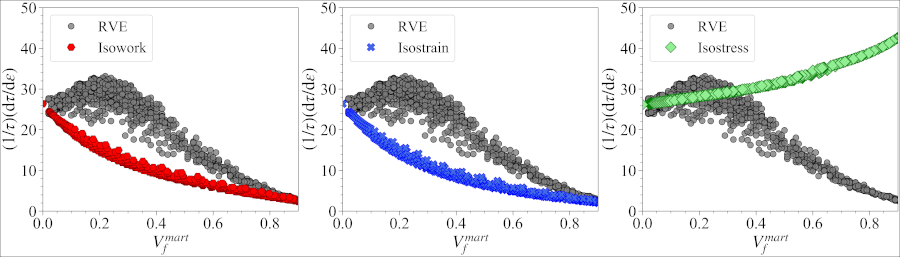

The demonstration that follows will show that with the Reification/Fusion approach we can use these reduced order models to optimize the RVE Model. In this process we use information contained in the reduced order models to provide information about the more expensive RVE Model and to build a fused model that can help us find a maximum in the RVE Model with relatively few RVE Model evaluations.

For this case study, we need to use Thermo-Calc to determine the volume fraction and composition of the ferrite and martensite phases. However, since we don't have access to the Thermo-Calc license on this system, there is a GP that is able to predict the volume fraction and composition of the ferrite and martensite phases. This GP has been trained on the output from Thermo-Calc and the specific details for how the GP is constructed can be found in our previous work. The next block of code creates the Thermo-Calc Gaussian Process model, and because it can take some time, we pickle the GP object and save it for easier recall later.

In [ ]:
with open("data/tc_gpObj.pkl", 'rb') as f:
    tc_gp = load(f)

The next three functions are the reduced order models that we will use in the Reification/Fusion approach. The general structure of these functions in targeted towards the implementation of these models in the BAREFOOT framework, but more will be said about that later. The main requirements are that these models need to take a single input which is an array or matrix with the design points from the unit hypercube of the design space, and must output a vector of results from each set of design points. To reduce the computational time, two of the original four dimensions are fixed. This allows the optimization to work in a 2D design space and reduces the time for constructing the GP models.

In [ ]:
import pandas as pd

def call_isowork(x_in):
    ep = 0.009
    if len(x_in.shape) == 1:
        x_in = np.expand_dims(x_in, axis=0)
    x = np.ones((x_in.shape[0],4))
    x[:,0] = 200*x_in[:,0] + 650
    x[:,1] = x_in[:,1]
    x[:,2] = x[:,2]*0.283
    x[:,3] = x[:,3]*0.328
    with open("data/tc_gpObj.pkl", 'rb') as f:
        tc_gp = load(f)
    tc_out = tc_gp.predict(x)
    return isowork_IS(tc_out, ep)

def call_isostrain(x_in):
    ep = 0.009
    if len(x_in.shape) == 1:
        x_in = np.expand_dims(x_in, axis=0)
    x = np.ones((x_in.shape[0],4))
    x[:,0] = 200*x_in[:,0] + 650
    x[:,1] = x_in[:,1]
    x[:,2] = x[:,2]*0.283
    x[:,3] = x[:,3]*0.328
    with open("data/tc_gpObj.pkl", 'rb') as f:
        tc_gp = load(f)
    tc_out = tc_gp.predict(x)
    return isostrain_IS(tc_out, ep)

def call_isostress(x_in):
    ep = 0.009
    if len(x_in.shape) == 1:
        x_in = np.expand_dims(x_in, axis=0)
    x = np.ones((x_in.shape[0],4))
    x[:,0] = 200*x_in[:,0] + 650
    x[:,1] = x_in[:,1]
    x[:,2] = x[:,2]*0.283
    x[:,3] = x[:,3]*0.328
    with open("data/tc_gpObj.pkl", 'rb') as f:
        tc_gp = load(f)
    tc_out = tc_gp.predict(x)
    return isostress_IS(tc_out, ep)

class RVE_GP():
    def __init__(self):
        self.mean = 0
        self.std = 0
        self.gp = 0
        self.setup()
        
    def setup(self):
        data = pd.read_excel('./data/rve_data.xlsx')
        data.iloc[:,0] = (data.iloc[:,0]-650)/200
        data.iloc[:,2] = data.iloc[:,2]/3
        data.iloc[:,3] = data.iloc[:,3]/2
        self.mean = np.mean(data.iloc[:,5])
        self.std = np.std(data.iloc[:,5])
        data.iloc[:,5] = (data.iloc[:,5]-self.mean)/self.std
        self.gp = gp_model(data.iloc[:,0:4], data.iloc[:,5], np.array([0.12274117, 0.08612411, 0.65729583, 0.23342798]), 0.16578065, 0.1, 4, 'SE')

    def predict(self, x_predict):
        if len(x_predict.shape) == 1:
            x_predict = np.expand_dims(x_predict, axis=0)
        x = np.ones((x_predict.shape[0],4))        
        x[:,0] = x_predict[:,0]           #Temperature
        x[:,1] = x_predict[:,1]           #wt% C
        x[:,2] = x[:,2]*0.283/2           #wt% Si
        x[:,3] = x[:,3]*0.328/3           #wt% Mn
        mean, var = self.gp.predict_var(x)
        
        return (mean*self.std + self.mean)

rve = RVE_GP() 

The ground truth model in this case (the RVE model) is generated as a Gaussian Process model.

To start the optimization we'll use two initial values from each of the models. These have been calculated separately and will be loaded into the Notebook. To ensure that we demonstrate the optimization, these are chosen to be very far from the optimum of the RVE model. The function calls that have been used to calculate the initial data are shown as a comment in the next code block.

In [ ]:
with open("data/initData.pickle", 'rb') as f:
        initDict = load(f)
        
"""
x_init = np.array([[0.9,0.9], [0.8,0.8]])

TMIn = deepcopy(x_init)
TMOut = rve.predict(deepcopy(x_init))
ROMOut = [call_isostrain(deepcopy(x_init)), 
          call_isostress(deepcopy(x_init)), 
          call_isowork(deepcopy(x_init))]
ROMIn = [deepcopy(x_init), deepcopy(x_init), deepcopy(x_init)]

initDict = {"TMInitOutput": TMOut,
            "TMInitInput": TMIn,
            "ROMInitOutput": ROMOut,
            "ROMInitInput": ROMIn}
"""

Now, as before, we want to specify all the parameters for the GP models. In this case, we've gone with fairly generic parameters. In this particular case it is possible to optimize the hyperparameters for the reduced order models, and because the RVE model is a GP and quick to evaluate, we could do the same for the error models. However, to show how the process would work if we can't do those kinds of evaluations we will stick with generic parameters.

In [ ]:
modelParam = {'model_l': [[0.1,0.1],[0.1,0.1],[0.1,0.1]],
                  'model_sf': [1,1,1],
                  'model_sn': [0.01, 0.01, 0.01],
                  'means': [0,0,0],
                  'std': [1,1,1],
                  'err_l': [[0.1,0.1],[0.1,0.1],[0.1,0.1]],
                  'err_sf': [1,1,1],
                  'err_sn': [0.01, 0.01, 0.01]}

Using the initial data and the parameters above, we create the reification object.

In [ ]:
reificationObj = model_reification(initDict['ROMInitInput'], initDict['ROMInitOutput'], 
                                   modelParam['model_l'], 
                                   modelParam['model_sf'], 
                                   modelParam['model_sn'], 
                                   modelParam['means'], 
                                   modelParam['std'], 
                                   modelParam['err_l'], 
                                   modelParam['err_sf'], 
                                   modelParam['err_sn'], 
                                   initDict['TMInitInput'], initDict['TMInitOutput'], 
                                   3, 2, "SE")

The next step will be to define the parameters to be used for the Fused GP Model as well as the points at which we need to evaluate the fused mean and variance. 

In [ ]:
fusedGP_hyperparam = {"sf": 15, "l_param": [0.1, 0.1]}
x_ = np.linspace(0,1,5)
x_fused = cartesian(x_,x_)

For the use of the Expected Improvement \[7\] acquisition function we will need to know the current maximum found as well as the $\xi$ parameter value, which in most cases can default to 0.01.

In [ ]:
curr_max = np.max(initDict['TMInitOutput'])
xi = 0.01

For plotting purposes we will also need to create lists to record the number of model calls for each model and the Maximum Values found.

In [ ]:
Output = [curr_max,curr_max]
rve_calls = [0,2]
isowork_calls = [2]
isostress_calls = [2]
isostrain_calls = [2]
iteration = [0]

The next part is a loop that cannot be broken up, so we'll discuss what the optimization is doing first and then run the code (For the sake of time, we'll start the code running and then start discussing what the code is doing since it will take at least a few minutes to run). 

When using the reification approach we only evaluate the Truth Model after a certain number of iterations. During all other iterations we need to define the reduced order model, and test point that we want to evaluate at each iteration. To do this we follow this method:

1) Evaluate the test points from one of the reduced order GP models

2) For each test point, temporarily update the fused GP model using the value from the GP model

3) Evaluate the acquisition function for each test point from the fused GP model and record which test point evaluated from the reduced order model has the largest acquisition function value

4) Repeat steps 1-3 for all other reduced order models

5) Then find which test point and model produced the largest acquisition function value

6) Evaluate that test point from the chosen model and update the reification object accordingly

7) Repeat steps 1-6 until the iteration limit has been reached for evaluating the Truth Model

8) Create the fused model, and evaluate it at a fine grid in the space

9) Then choose the input that corresponds with the maximum in the fused model (this is a greedy approach, any acquisition function can be used instead)

10) Evaluate this point from the Truth Model and update the reification object

11) Repeat steps 1-10 until the total iteration limit is reached 


In [ ]:
%matplotlib notebook

def pltsin1(ax, x, y):
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            line.set_ydata(y)
    else:
         ax.plot(x, y)
    fig.canvas.draw()
    
def pltsin3(ax, x, y):
    if ax.lines:
        ii = 0
        for line in ax.lines:
            line.set_xdata(x[ii])
            line.set_ydata(y[ii])
            ii += 1
    else:
        ax.plot(x[0], y[0], label="Isostrain")
        ax.plot(x[1], y[1], label="Isostress")
        ax.plot(x[2], y[2], label="Isowork")
        ax.legend()
    fig.canvas.draw()

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_xlabel('RVE Evaluations')
ax[0].set_ylabel('$1/\sigma(d\sigma/d\epsilon_{pl})$')
ax[0].set_xlim(0,20)
ax[0].set_xticks([0,2,4,6,8,10,12,14,16,18,20])
ax[0].set_ylim(0,35)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Model Evaluations')
ax[1].set_xlim(0,90)
ax[1].set_ylim(0,40)



for mm in range(90):
    iteration.append(mm+1)
    x_test = lhs(2,20)
    max_EI = -1e6
    x_index = -1
    model_index = -1
    
    for ii in range(3):
        mean, var = reificationObj.predict_low_order(deepcopy(x_test), ii)
        
        for jj in range(20):
            reifi_copy = deepcopy(reificationObj)
            reifi_copy.update_GP(deepcopy(x_test)[jj,:], mean[jj], ii)
            reifi_copy.create_fused_GP(x_fused, fusedGP_hyperparam["l_param"], fusedGP_hyperparam['sf'], 0.05, "SE")
            mean, cov = reifi_copy.predict_fused_GP(deepcopy(x_test))
            max_val, x_star, EI = expected_improvement(curr_max, xi, mean, np.diag(cov))
            if max_val > max_EI:
                max_EI = max_val
                x_index = jj
                model_index = ii

    if model_index == 0:
        new_y = call_isostrain(deepcopy(x_test)[x_index])
        isostrain_calls.append(isostrain_calls[-1]+1)
        isostress_calls.append(isostress_calls[-1])
        isowork_calls.append(isowork_calls[-1])
    elif model_index == 1:
        new_y = call_isostress(deepcopy(x_test)[x_index])
        isostrain_calls.append(isostrain_calls[-1])
        isostress_calls.append(isostress_calls[-1]+1)
        isowork_calls.append(isowork_calls[-1])
    elif model_index == 2:
        new_y = call_isowork(deepcopy(x_test)[x_index])
        isostrain_calls.append(isostrain_calls[-1])
        isostress_calls.append(isostress_calls[-1])
        isowork_calls.append(isowork_calls[-1]+1)

    reificationObj.update_GP(deepcopy(x_test)[x_index], new_y, model_index)

    if (mm+1) % 5 == 0:
        x_ = np.linspace(0,1,10)
        x_test = cartesian(x_,x_)
        reificationObj.create_fused_GP(x_fused, fusedGP_hyperparam['l_param'],
                                      fusedGP_hyperparam['sf'], 0.05, 'SE')
        mean, cov = reificationObj.predict_fused_GP(deepcopy(x_test))
        x_index = np.where(mean == np.max(mean))[0]
        if x_index.shape[0] > 1:
            x_index = x_index[0]
        new_RVE = rve.predict(deepcopy(x_test)[x_index])
        reificationObj.update_truth(deepcopy(x_test)[x_index], new_RVE)
        if np.max(new_RVE) > Output[-1]:
            Output.append(new_RVE)
        else:
            Output.append(Output[-1])
        rve_calls.append(rve_calls[-1]+1)
               
    pltsin1(ax[0], rve_calls, Output)
    pltsin3(ax[1], [iteration, iteration, iteration],
                   [isostrain_calls, isostress_calls, isowork_calls])
    

What must be noted in these results is that the process is stochastic. Mutliple runs with the exact same starting point can produce different results. 

Since it is outside the scope of the demonstration that is being done, a set of 30 calculations with the same initial data have been completed already. The results below show the average output with the filled area being 2 standard deviations (or an approximate 95% confidence interval). We can see that this approach works quite well at optimizing the RVE model, needing only around 30 model evaluations before we see the maximum found reaching a plateau. 

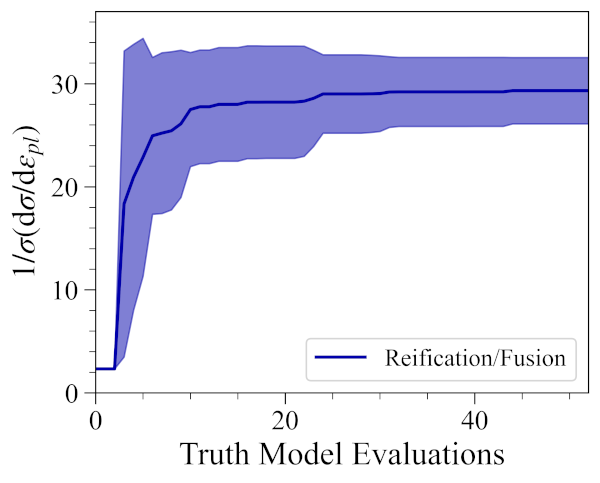

## References

\[1\] Thomison, William D., and Douglas L. Allaire. “A Model Reification Approach to Fusing Information from Multifidelity Information Sources.” In 19th AIAA Non-Deterministic Approaches Conference. AIAA SciTech Forum. American Institute of Aeronautics and Astronautics, 2017. https://doi.org/10.2514/6.2017-1949.

\[2\] Couperthwaite, Richard, Abhilash Molkeri, Danial Khatamsaz, Ankit Srivastava, Douglas Allaire, and Raymundo Arroyave. “Materials Design Through Batch Bayesian Optimization with Multisource Information Fusion.” JOM, October 13, 2020. https://doi.org/10.1007/s11837-020-04396-x.

\[3\] Ghoreishi, Seyede Fatemeh, Abhilash Molkeri, Raymundo Arróyave, Douglas Allaire, and Ankit Srivastava. “Efficient Use of Multiple Information Sources in Material Design.” Acta Materialia 180 (2019): 260–71.

\[4\]Ghoreishi, Seyede Fatemeh, Abhilash Molkeri, Ankit Srivastava, Raymundo Arroyave, and Douglas Allaire. “Multi-Information Source Fusion and Optimization to Realize ICME: Application to Dual-Phase Materials.” Journal of Mechanical Design 140, no. 11 (September 7, 2018): 111409-111409–14. https://doi.org/10.1115/1.4041034.

\[5\] Khatamsaz, Danial, Abhilash Molkeri, Richard Couperthwaite, Jaylen James, Raymundo Arróyave, Douglas Allaire, and Ankit Srivastava. “Efficiently Exploiting Process-Structure-Property Relationships in Material Design by Multi-Information Source Fusion.” Acta Materialia 206 (March 1, 2021): 116619. https://doi.org/10.1016/j.actamat.2020.116619.

\[6\] R. Winkler, “Combining probability distributions from dependent information sources,” Management Science, vol. 27, no. 4, pp. 479–488, 1981

\[7\] Močkus, J. “On Bayesian Methods for Seeking the Extremum.” In Optimization Techniques IFIP Technical Conference Novosibirsk, July 1–7, 1974, edited by G. I. Marchuk, 400–404. Berlin, Heidelberg: Springer Berlin Heidelberg, 1975.

